<img src="Screenshot_26-2-2025_164927_www.agrisarathi.com-removebg-preview.png"  width="300" height="250">


# 🌾 GenAI-Powered Crop Disease Detection & Smart Recommendation System for Farmers 🌱🤖👨‍🌾

**GROUP MEMBERS :**
- Krina Gajera -B022
- Suraj Temkar -B015
- Yash Sawalka -B011

#### **Dataset:**

---


**Which Dataset we used?**

We combined five high-quality datasets, including PlantVillage and Crop Diseases Dataset (Kaggle) and Farming Disease Image Dataset (FAO), to create a powerful AI-driven crop health dataset. This enriched collection ensures accurate disease detection across diverse crops, empowering farmers with AI insights. 🌱🚜💡

**Details of the Dataset:**

- Number of Images: The dataset contains 20,638 pictures.
- Plant Species: These pictures show 13 different types of plants.
- Classes: There are 30 different categories in the dataset. These categories include both healthy plants and plants with various diseases.

# Vision Transformer Model

In [72]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.checkpoint import checkpoint


In [73]:
n_embd=768
mlp_dim=3072
patch_size=14
n_layers=6
n_heads=8
dropout=0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
data_dir='Content/input/Combined_Diseaseddataset'

## Data Augmentation

In [76]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
])

dataset = ImageFolder(data_dir,transform=transform)

In [77]:
train_size=int(0.8*len(dataset))
val_size=int(0.1*len(dataset))
test_size= len(dataset)-train_size-val_size

train_data,val_data,test_data=random_split(dataset,[train_size,val_size,test_size])
print(len(train_data),len(val_data),len(test_data))

16510 2063 2065


In [78]:
img ,label=train_data[2900]
print(img.shape)

torch.Size([3, 224, 224])


In [ ]:
from collections import Counter

# Flatten the list of lists for classes
flattened_classes = [item for sublist in train_class_texts for item in sublist]

# Count occurrences of each class
class_counts = Counter(flattened_classes)

# Select unique classes
unique_classes = set(flattened_classes)

print(f'There are {len(unique_classes)} unique classes.\n')

# Print the unique classes and their counts
for cls, count in class_counts.items():
    print(f'{cls}: {count}')


There are 30 unique classes.

Tomato Septoria leaf spot: 402
Bell_pepper leaf: 312
Potato leaf early blight: 301
grape leaf black rot: 125
Corn rust leaf: 117
Corn leaf blight: 356
Tomato leaf yellow virus: 759
Strawberry leaf: 462
Blueberry leaf: 816
Tomato mold leaf: 279
Raspberry leaf: 539
Tomato leaf late blight: 204
Tomato leaf bacterial spot: 266
Soyabean leaf: 246
Tomato Early blight leaf: 193
Corn Gray leaf spot: 72
Squash Powdery mildew leaf: 248
Apple leaf: 237
Apple rust leaf: 167
Cherry leaf: 220
Tomato leaf mosaic virus: 225
Bell_pepper leaf spot: 248
Peach leaf: 604
Potato leaf late blight: 235
Tomato leaf: 373
grape leaf: 205
Apple Scab Leaf: 158
Tomato two spotted spider mites leaf: 2
Soybean leaf: 15
Potato leaf: 11


## Visualising the data

Class: Tomato_Leaf_Mold , Label: 8


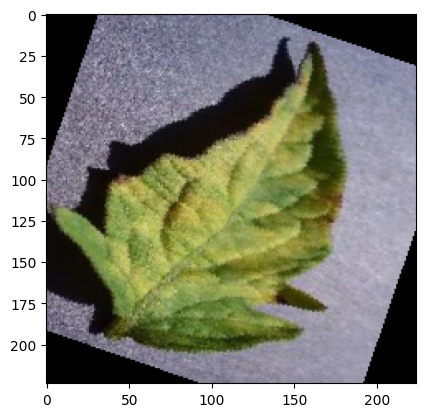

In [79]:
import matplotlib.pyplot as plt
print('Class:',dataset.classes[label],',','Label:',label)
plt.imshow(img.permute(1,2,0))

In [80]:
batch_size=128
train_dl=DataLoader(train_data,batch_size,shuffle=True)
val_dl=DataLoader(val_data,batch_size*2,shuffle=True)
test_dl=DataLoader(test_data,32,shuffle=False)

In [81]:
class PatchEmbeddings(nn.Module):
    def __init__(self,img_size,n_embd,patch_size):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch=nn.Conv2d(3,n_embd,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten=nn.Flatten(2,3)
    def forward(self,x):
        x=self.patch(x)
        x=self.flatten(x)
        return x.permute(0,2,1)  

In [82]:
class PositionalEncoding(nn.Module):
    def __init__(self,n_patches,n_embd):
        super().__init__()
        self.pos=nn.Parameter(torch.randn(1,n_patches+1,n_embd),requires_grad=True)
    def forward(self,x):
        return x+self.pos

## Defining Model Architechture


In [83]:
class TransformerEncoder(nn.Module):
    def __init__(self,n_embd,n_heads,mlp_dim,dropout=dropout):
        super().__init__()
        self.l1=nn.LayerNorm(n_embd)
        self.l2=nn.LayerNorm(n_embd)
        self.attn=nn.MultiheadAttention(n_embd,n_heads,dropout=0,batch_first=True)
        self.mlp=nn.Sequential(
            nn.Linear(n_embd,mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim,n_embd),
            nn.Dropout(dropout)
        
        )
    def forward(self,x):
        x=self.l1(x)
        attn_out,_=self.attn(x,x,x)
        x=x+attn_out
        x=self.l2(x)
        mlp_out=self.mlp(x)
        x=x+mlp_out
        
        return x
    

In [84]:
class VisionTransformer(nn.Module):
    def __init__(self,img_size,num_classes,n_embd,patch_size,n_layers,n_heads,mlp_dim,dropout):
        super().__init__()
        self.patchify=PatchEmbeddings(img_size,n_embd,patch_size)
        self.n_patches=self.patchify.num_patches
        self.pos_encodings=PositionalEncoding(self.n_patches,n_embd)
        self.transformer_encoder=nn.ModuleList([TransformerEncoder(n_embd,n_heads,mlp_dim,dropout) for _ in range(n_layers)])
        self.cls_token=nn.Parameter(torch.randn(1,1,n_embd),requires_grad=True)
        self.mlp_head=nn.Sequential(
            nn.LayerNorm(n_embd),
            nn.Linear(n_embd,num_classes)
            
        )
    def forward(self,x):
        batch_size=x.shape[0]
        x=self.patchify(x)
        cls_tokens=self.cls_token.expand(batch_size,-1,-1)
        x=torch.cat([cls_tokens,x],dim=1)
        x=self.pos_encodings(x)

        for layer in self.transformer_encoder:
            x=checkpoint(layer,x,use_reentrant=False)
            
        cls_token_final=x[:,0]
        logits=self.mlp_head(cls_token_final)
        
        return logits

## Train and eval function

In [85]:
@torch.no_grad()
def evaluate(model,val_dl,criterion):
    model.eval()
    total=0
    correct=0
    batch_losses=[]
    for img,label in val_dl:
        img,label=img.to(device),label.to(device)
        logits = model(img)
        loss = criterion(logits, label)
        batch_losses.append(loss)
        _,predicted=torch.max(logits.data,1)
        total+=label.size(0)
        correct+=(predicted==label).sum().item()
    val_loss=torch.stack(batch_losses).mean()
    val_acc=(correct/total)*100
    return {'val_loss':val_loss,'val_acc':val_acc}

def train(n_epochs,lr,model,train_dl,val_dl,criterion,opt_func):
    model.train()
    optimizer=opt_func(model.parameters(),lr)
    history=[]
    for epoch in range(n_epochs):
        train_losses=[]
        total=0
        correct=0
        for img,label in train_dl:
            img,label=img.to(device),label.to(device)
            optimizer.zero_grad()
            logits = model(img)
            loss = criterion(logits, label)
            train_losses.append(loss)
            _,predicted=torch.max(logits.data,1)
            total+=label.size(0)
            correct+=(predicted==label).sum().item()
            loss.backward()
            optimizer.step()
            
        result=evaluate(model,val_dl,criterion)
        train_loss=torch.stack(train_losses).mean()
        train_acc=(correct/total)*100
        result['train_loss']=train_loss
        result['train_acc']=train_acc
        print(f'Epoch:{epoch},train_loss:{result["train_loss"]},train_acc:{result["train_acc"]},val_loss:{result["val_loss"]},val_acc:{result["val_acc"]}')
        history.append(result)
    return history 

In [86]:
model=VisionTransformer(224,num_classes,n_embd,patch_size,n_layers,n_heads,mlp_dim,dropout)
model=model.to(device)

In [87]:
n_epochs=20
optim_func=optim.Adam
lr=3e-5
criterion=nn.CrossEntropyLoss()

## Model Training

In [88]:
history=train(n_epochs,lr,model,train_dl,val_dl,criterion,optim_func)

Epoch:0,train_loss:2.3795130252838135,train_acc:22.1320411871593,val_loss:2.1026790142059326,val_acc:30.5865244789142
Epoch:1,train_loss:1.872321367263794,train_acc:38.82495457298607,val_loss:1.8585354089736938,val_acc:38.923897237033444
Epoch:2,train_loss:1.4474470615386963,train_acc:52.707450030284676,val_loss:1.1858699321746826,val_acc:61.26999515269026
Epoch:3,train_loss:1.1945669651031494,train_acc:60.72683222289521,val_loss:1.0830084085464478,val_acc:64.46921958313136
Epoch:4,train_loss:1.0314347743988037,train_acc:66.03270745003029,val_loss:0.8971360325813293,val_acc:70.96461463887542
Epoch:5,train_loss:0.9373134970664978,train_acc:69.30950938824955,val_loss:0.883995532989502,val_acc:71.25545322346098
Epoch:6,train_loss:0.8138020634651184,train_acc:73.07086614173228,val_loss:0.7434757947921753,val_acc:76.15123606398448
Epoch:7,train_loss:0.7038759589195251,train_acc:76.45669291338582,val_loss:0.6368324756622314,val_acc:77.94474066892874
Epoch:8,train_loss:0.6364988088607788,trai

In [89]:
test_result=evaluate(model,test_dl,criterion)
print(f'Test accuracy is:{test_result["val_acc"]}')

Test accuracy is:91.38014527845037


In [101]:
torch.save(model.state_dict(), 'ViT_classification_weights.pth')

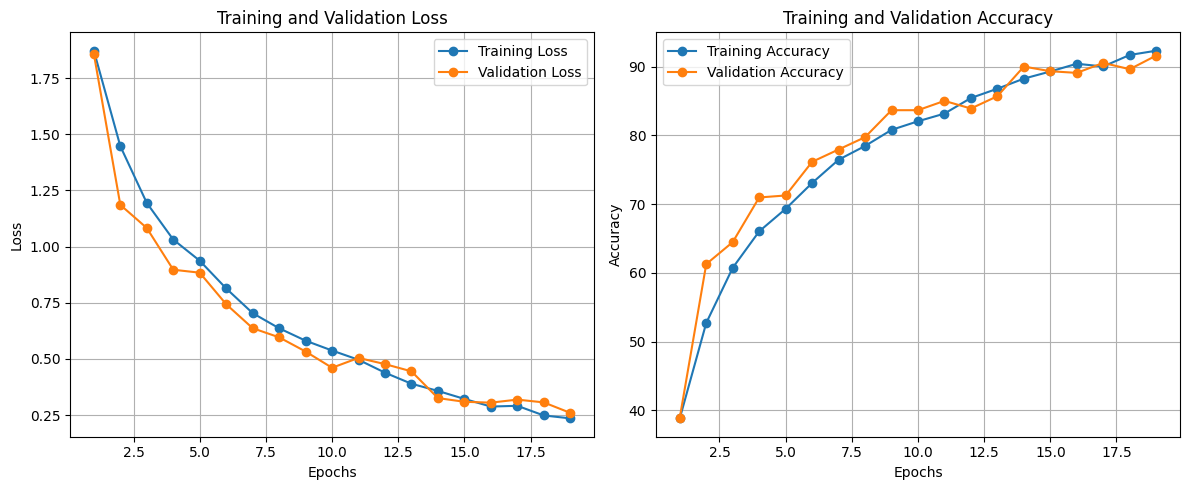

In [98]:
import matplotlib.pyplot as plt

# Assuming history is a dictionary that has 'train_loss', 'val_loss', 'train_acc', and 'val_acc' for each epoch
epoch = list(range(1, 20))  # Adjust this according to your actual number of epochs

# Extract training and validation losses as lists
train_loss = [history[i]["train_loss"].cpu().item() for i in epoch]
val_loss = [history[j]["val_loss"].cpu().item() for j in epoch]

# Extract training and validation accuracies as lists
train_acc = [history[i]["train_acc"] for i in epoch]
val_acc = [history[j]["val_acc"] for j in epoch]

# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Create a subplot for Loss
plt.plot(epoch, train_loss, label='Training Loss', marker='o')
plt.plot(epoch, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)  # Create a subplot for Accuracy
plt.plot(epoch, train_acc, label='Training Accuracy', marker='o')
plt.plot(epoch, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Visualising Predictions

Prediction: Tomato__Tomato_mosaic_virus
Ground Truth: Tomato__Tomato_mosaic_virus


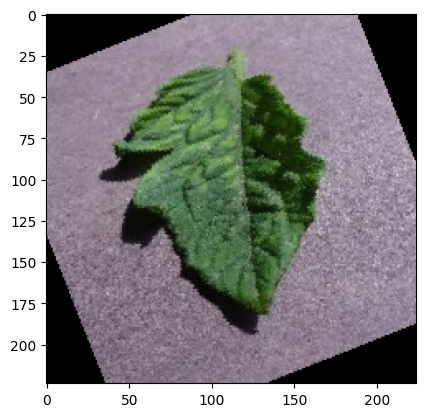

In [109]:
for img,label in test_dl:
    img,label=img.to(device),label.to(device)
    out=model(img)
    _,pred=torch.max(out,dim=1)
    plt.imshow(img[1].permute(1,2,0).cpu().numpy())
    print("Prediction:",dataset.classes[pred[1]])
    print("Ground Truth:",dataset.classes[label[1]])
    break

# Yolov8 model

In [ ]:
#The ultralytics package is essential for leveraging YOLO (You Only Look Once) models in object detection tasks due to its simplicity and effectiveness.
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
# Install essential libraries and modules.
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO8
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from IPython.display import Image
import numpy as np
from collections import defaultdict

# DATA DOWNLOAD AND LOADING

**Observation:** We can see that diseased images have the following terms in their classes: [blight, rust, spot, rot, mite, bacteria, mildew, virus, scab, squash, powdery]

**Displaying Histograms of the Width and Height of Images**

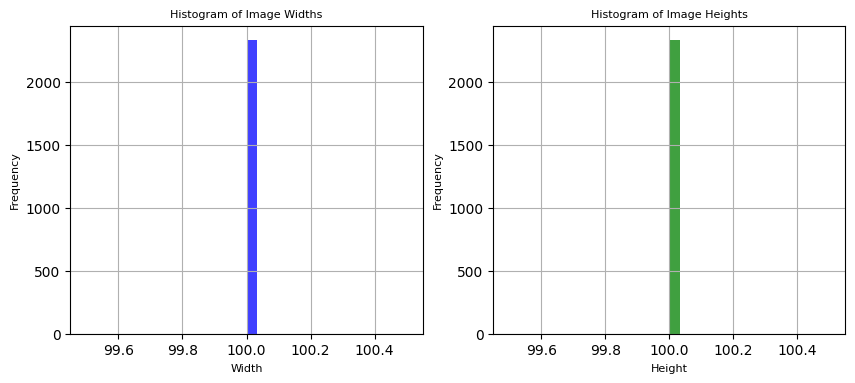

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram of image widths.
ax[0].hist(train_widths, bins=30, alpha=0.75, color='b')
ax[0].set_xlabel('Width', fontsize=8)
ax[0].set_ylabel('Frequency', fontsize=8)
ax[0].set_title('Histogram of Image Widths', fontsize=8)
ax[0].grid(True)

# Plot histogram of image heights.
ax[1].hist(train_heights, bins=30, alpha=0.75, color='g')
ax[1].set_xlabel('Height', fontsize=8)
ax[1].set_ylabel('Frequency', fontsize=8)
ax[1].set_title('Histogram of Image Heights', fontsize=8)
ax[1].grid(True)

**Observation:** The histograms of width and height indicate that the dimensions of the images are consistently 416 x 416 pixels.

**Displaying the Image Formats**

In [ ]:
train_image_formats[0:5]

['jpeg', 'jpeg', 'jpeg', 'jpeg', 'jpeg']

**Mapping the Classes**

In [ ]:
label_map_path = 'Content/input/Combined_Diseaseddataset/train/leaves_label_map.pbtxt'
label_map = read_label_map(label_map_path)

# Ensure all 30 classes are loaded.
expected_num_classes = 30
actual_num_classes = len(label_map)

if actual_num_classes < expected_num_classes:
    print(f"Warning: Only {actual_num_classes} classes loaded from {label_map_path}. Expected {expected_num_classes}.")
elif actual_num_classes > expected_num_classes:
    print(f"Warning: Loaded {actual_num_classes} classes from {label_map_path}. Expected {expected_num_classes}.")
else:
    print(f"Successfully loaded {actual_num_classes} classes from {label_map_path}.")

# Print all class names and IDs.
for id, name in label_map.items():
    print(f'ID: {id} | Name: {name}')

ID: 1 | Name: "Apple leaf",
ID: 2 | Name: "Apple rust leaf",
ID: 3 | Name: "Bell_pepper leaf",
ID: 4 | Name: "Bell_pepper leaf spot",
ID: 5 | Name: "Blueberry leaf",
ID: 6 | Name: "Cherry leaf",
ID: 7 | Name: "Corn Gray leaf spot",
ID: 8 | Name: "Corn leaf blight",
ID: 9 | Name: "Corn rust leaf",
ID: 10 | Name: "Peach leaf",
ID: 11 | Name: "Potato leaf",
ID: 12 | Name: "Potato leaf early blight",
ID: 13 | Name: "Potato leaf late blight",
ID: 14 | Name: "Raspberry leaf",
ID: 15 | Name: "Soyabean leaf",
ID: 16 | Name: "Soybean leaf",
ID: 17 | Name: "Squash Powdery mildew leaf",
ID: 18 | Name: "Strawberry leaf",
ID: 19 | Name: "Tomato Early blight leaf",
ID: 20 | Name: "Tomato Septoria leaf spot",
ID: 21 | Name: "Tomato leaf",
ID: 22 | Name: "Tomato leaf bacterial spot",
ID: 23 | Name: "Tomato leaf late blight",
ID: 24 | Name: "Tomato leaf mosaic virus",
ID: 25 | Name: "Tomato leaf yellow virus",
ID: 26 | Name: "Tomato mold leaf",
ID: 27 | Name: "Tomato two spotted spider mites leaf",
ID:

In [ ]:
# Define the content of data.yaml.
yaml_content = """
train: Content/input/Combined_Diseaseddataset/output_dir/train/images  # Directory containing training images
val:Content/input/Combined_Diseaseddataset/output_dir/test/images  # Directory containing test images
nc: 30  # Number of classes

names:
  - "Apple Scab Leaf"
  - "Apple leaf"
  - "Apple rust leaf"
  - "Bell_pepper leaf"
  - "Bell_pepper leaf spot"
  - "Blueberry leaf"
  - "Cherry leaf"
  - "Corn Gray leaf spot"
  - "Corn leaf blight"
  - "Corn rust leaf"
  - "Peach leaf"
  - "Potato leaf"
  - "Potato leaf early blight"
  - "Potato leaf late blight"
  - "Raspberry leaf"
  - "Soyabean leaf"
  - "Soybean leaf"
  - "Squash Powdery mildew leaf"
  - "Strawberry leaf"
  - "Tomato Early blight leaf"
  - "Tomato Septoria leaf spot"
  - "Tomato leaf"
  - "Tomato leaf bacterial spot"
  - "Tomato leaf late blight"
  - "Tomato leaf mosaic virus"
  - "Tomato leaf yellow virus"
  - "Tomato mold leaf"
  - "Tomato two spotted spider mites leaf"
  - "grape leaf"
  - "grape leaf black rot"
"""

# Write yaml_content to data.yaml.
with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

In [ ]:
# Define paths to the images and labels directories.
images_dir = 'Content/input/Combined_Diseaseddataset/train/images'
labels_dir = 'Content/input/Combined_Diseaseddataset/train/labels'

# Get the list of images in the images directory.
image_files = os.listdir(images_dir)

# DATA RESIZE, NORMALIZATION AND FEATURE EXTRACTION

We will use a pretrained model VGG16 to extract features from the images.

In [ ]:
# Load pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Directory containing all images.
all_image_paths = 'Content/input/Combined_Diseaseddataset/train/images/'
all_image_paths = [os.path.join(all_image_paths, fname) for fname in os.listdir(all_image_paths) if fname.endswith('.jpg')]

# Extract features for all images.
# 'all_features' contains flattened arrays.
all_features = np.array([extract_features(img_path) for img_path in all_image_paths])

# HANDLING CLASS IMABALANCE AND UNREPRESENTED CLASSES

# DATA AUGMENTATION

In [ ]:
# Define the sequence of augmentations.
seq = iaa.Sequential([

    # Adjust contrast of the image randomly between 0.5 and 1.5 times the original contrast.
    iaa.ContrastNormalization((0.5, 1.5)),

    # Adjust brightness by multiplying pixel values by a factor between 0.8 and 1.2.
    iaa.Multiply((0.8, 1.2)),

    # Flip the image horizontally with a 50% chance.
    iaa.Fliplr(0.5),

    # Randomly crop the image with the crop percentage varying between 0% and 10%.
    iaa.Crop(percent=(0, 0.1)),

    # Rotate the image randomly between -10 and 10 degrees.
    iaa.Affine(rotate=(-10, 10)),

])

In [ ]:
# Saving the images after applying data augmentation methods such as flipping, rotating, cropping, adjusting brightness, adjusting contrast, and removing unrepresented classes
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Read the image, convert it to RGB as imgaug works with RGB images.
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the bounding boxes from label file.
    bbs = []
    exclude_image = False  # Flag to determine whether to exclude the image

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_label = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            if class_label in {11, 15, 27}:
                exclude_image = True  # Set flag to True if label is in the exclude list
                break  # Stop processing this image if any label is to be excluded

            # Convert to absolute coordinates as required by Yolo.
            x1 = int((x_center - width/2) * image.shape[1])
            y1 = int((y_center - height/2) * image.shape[0])
            x2 = int((x_center + width/2) * image.shape[1])
            y2 = int((y_center + height/2) * image.shape[0])

            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=class_label))

    if exclude_image:
        # Delete the image and label file
        if os.path.exists(image_path):
            os.remove(image_path)
        if os.path.exists(label_path):
            os.remove(label_path)
        print(f"Deleted image and label due to labels: {image_file}")
        continue  # Skip the rest of the loop if this image is excluded

    # Create BoundingBoxesOnImage object with bounding boxes and shape of image.
    bbs = BoundingBoxesOnImage(bbs, shape=image.shape)

    # Augment image and bounding boxes.
    augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)

    # Convert augmented image back to BGR.
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

    # Save augmented image.
    short_identifier = generate_short_identifier(image_file)
    augmented_image_name = f"augmented_{short_identifier}.jpg"
    augmented_image_path = os.path.join(images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, augmented_image)
    print(f"Saved augmented image: {augmented_image_path}")

    # Update labels file with augmented bounding boxes.
    augmented_label_name = f"{short_identifier}_augmented.txt"
    augmented_label_path = os.path.join(labels_dir, augmented_label_name)
    with open(augmented_label_path, 'w') as f:
        for bb in augmented_bbs.bounding_boxes:
            # Convert bounding box coordinates back to relative values.
            center_x = (bb.x1 + bb.x2) / 2 / image.shape[1]
            center_y = (bb.y1 + bb.y2) / 2 / image.shape[0]
            width = (bb.x2 - bb.x1) / image.shape[1]
            height = (bb.y2 - bb.y1) / image.shape[0]
            f.write(f"{bb.label} {center_x} {center_y} {width} {height}\n")
    print(f"Updated labels file: {augmented_label_path}")


Saved augmented image: /content/PlantDoc-1/train/images/augmented_cac5fd46.jpg
Updated labels file: /content/PlantDoc-1/train/labels/cac5fd46_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_4c5321b0.jpg
Updated labels file: /content/PlantDoc-1/train/labels/4c5321b0_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_03b82c02.jpg
Updated labels file: /content/PlantDoc-1/train/labels/03b82c02_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_3617c934.jpg
Updated labels file: /content/PlantDoc-1/train/labels/3617c934_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_abb66bc3.jpg
Updated labels file: /content/PlantDoc-1/train/labels/abb66bc3_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_1fe66905.jpg
Updated labels file: /content/PlantDoc-1/train/labels/1fe66905_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmente

# MODELING

In [ ]:
#Initialize YOLO model
model = YOLO('yolov8m.yaml')

**Important:**

Open the data.yaml file placed in /Desktop/PlantVillage Dataset-1 and update the training,  val and test paths as follows:

train: Content/input/Combined_Diseaseddataset/train/images

test: Content/input/Combined_Diseaseddataset/test/images

val: Content/input/Combined_Diseaseddataset/test/images

Remove the underrepresented classes:

- Potato leaf
- Soybean leaf
- Tomato Two Spotted Spider Mites leaf

**Training the Model**

In [ ]:
epochs=100
batch_size=16

!yolo task=detect mode=train model=yolov8m.yaml data=/content/PlantDoc-1/data.yaml epochs=100 imgsz=416 batch=16

Ultralytics YOLOv8.2.64 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/PlantDoc-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

**Observations**


Validation:
* mAP50: Mean Average Precision (mAP) at IoU (Intersection over Union) threshold of 0.471.
* mAP50-95: mAP across different IoU thresholds 0.363.


**Miscellaneous Results**

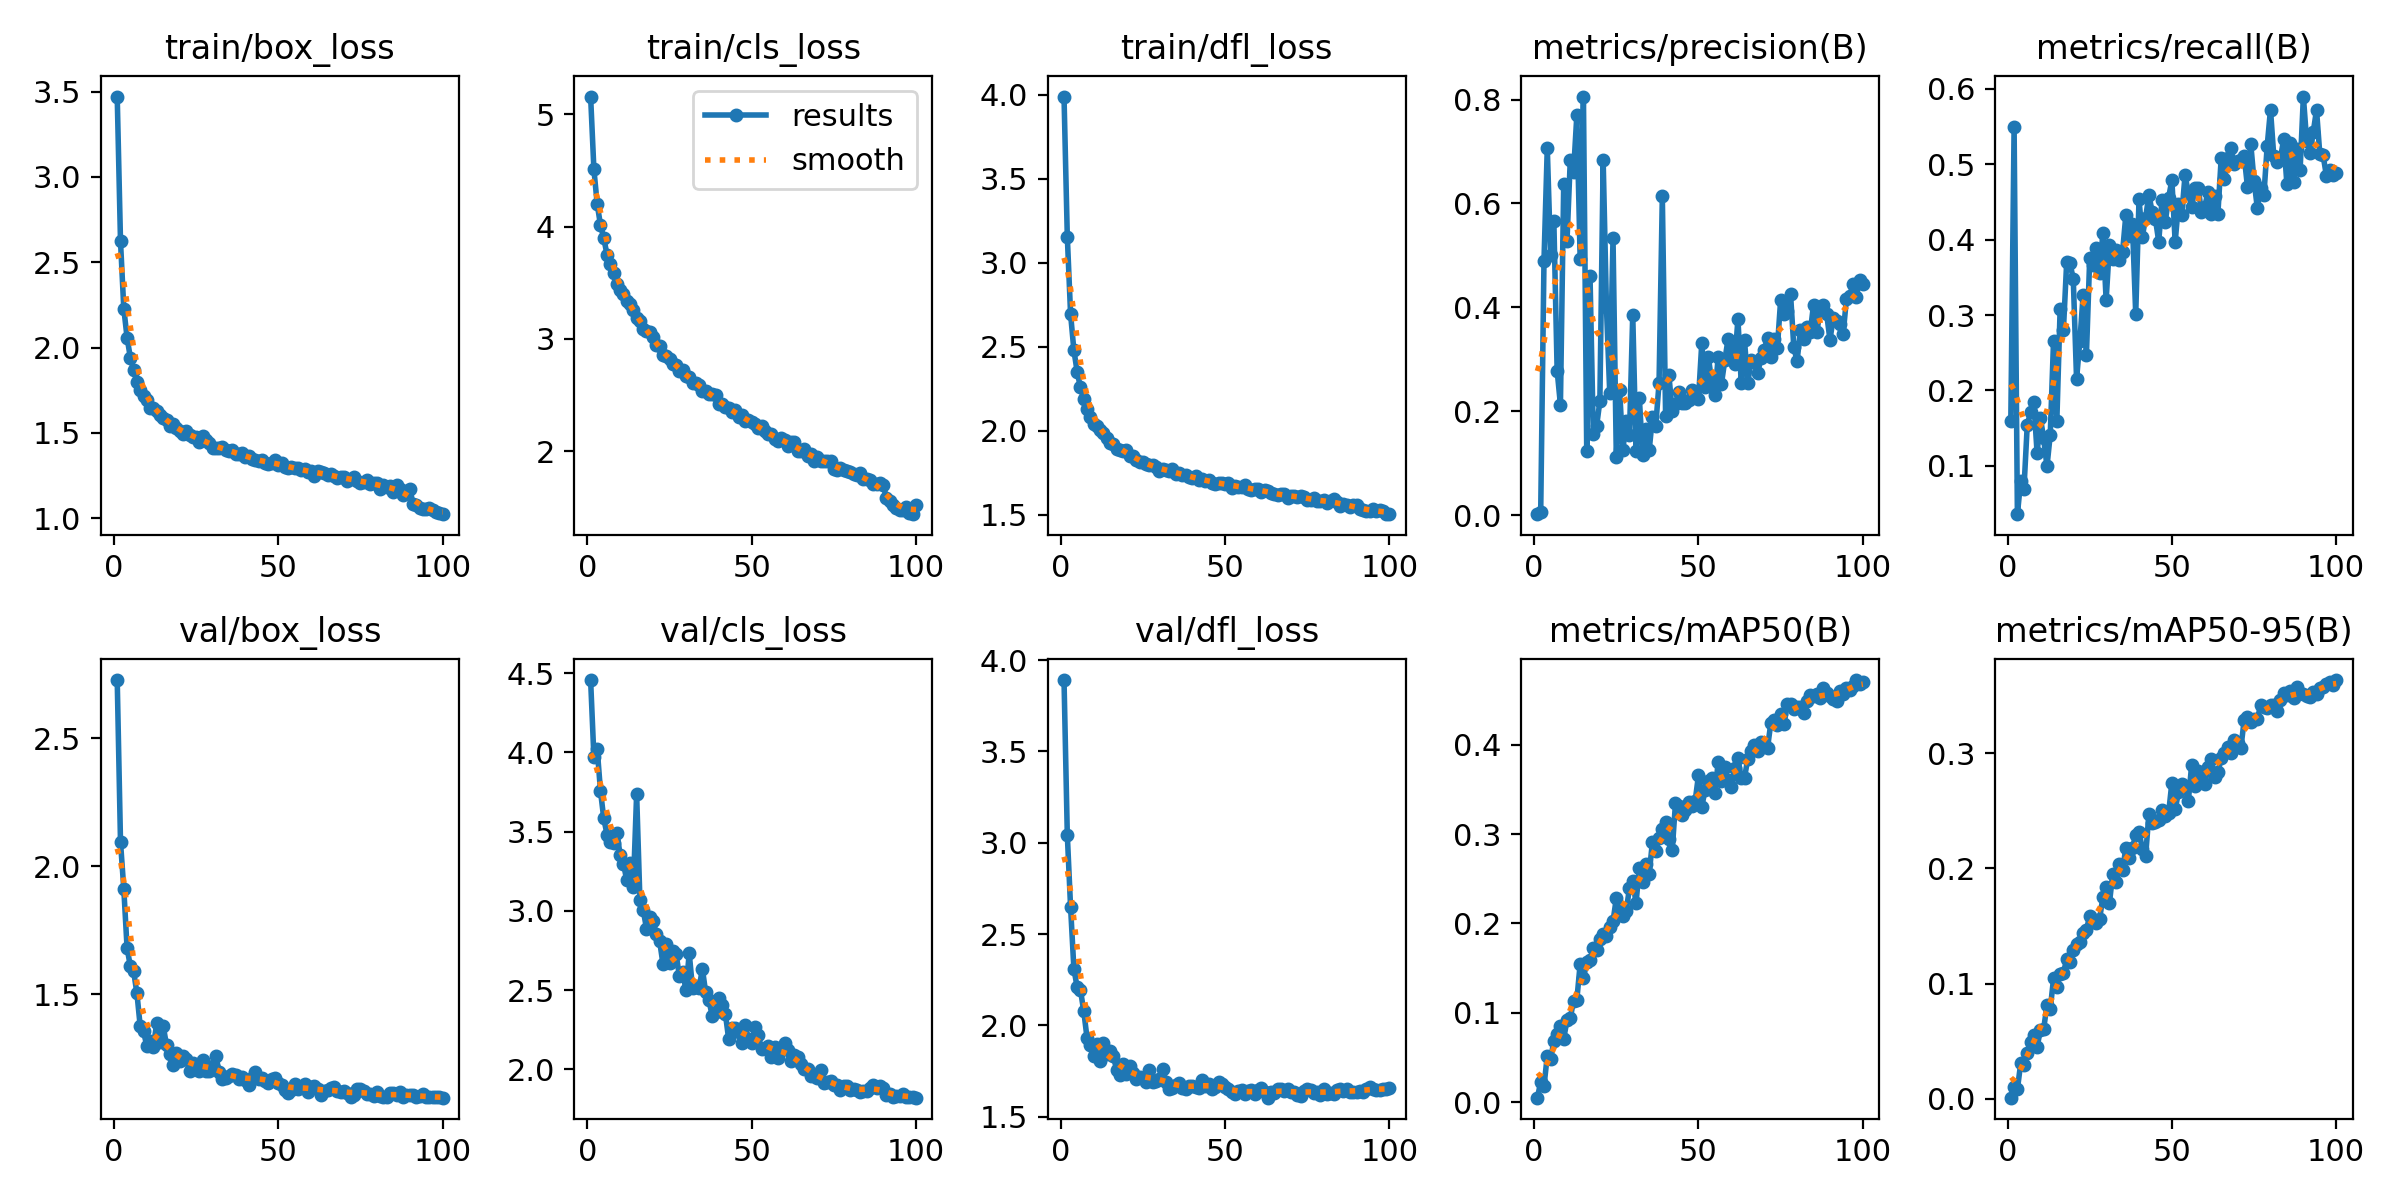

In [ ]:
Image(filename=f'Content/input/Combined_Diseaseddataset/runs/detect/train5/results.png')

In [ ]:
model = YOLO("Content/input/Combined_Diseaseddataset/runs/detect/train3/weights/best.pt")

### Testing models on some images

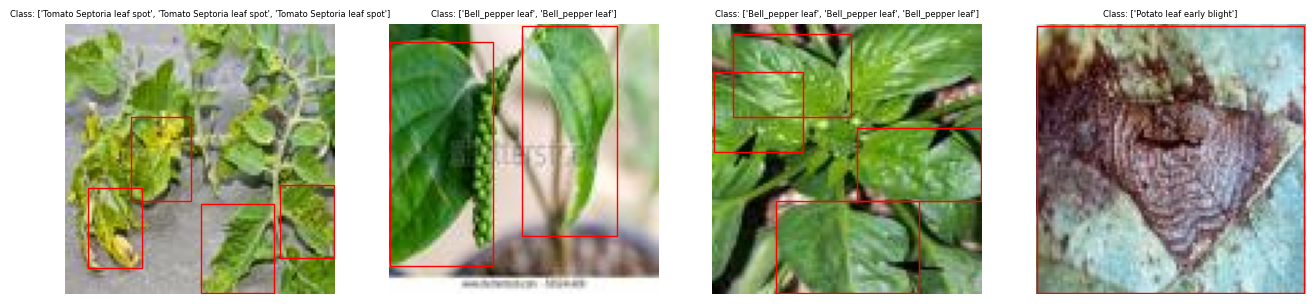

In [ ]:

# Set the number of images to display
num_example = 4

fig, ax = plt.subplots(1, num_example, figsize=(16, 4))

for i in range(num_example):
    title = f'Class: {train_class_texts[i][0:num_example-1]}'

    ax[i].imshow(train_images[i])
    ax[i].axis('off')
    ax[i].set_title(title, fontsize=6)

    # Draw bounding boxes on the images.
    for bbox in train_bboxes[i]:
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin * train_widths[i], ymin * train_heights[i]), (xmax - xmin) * train_widths[i], (ymax - ymin) * train_heights[i], linewidth=1, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)

plt.show()

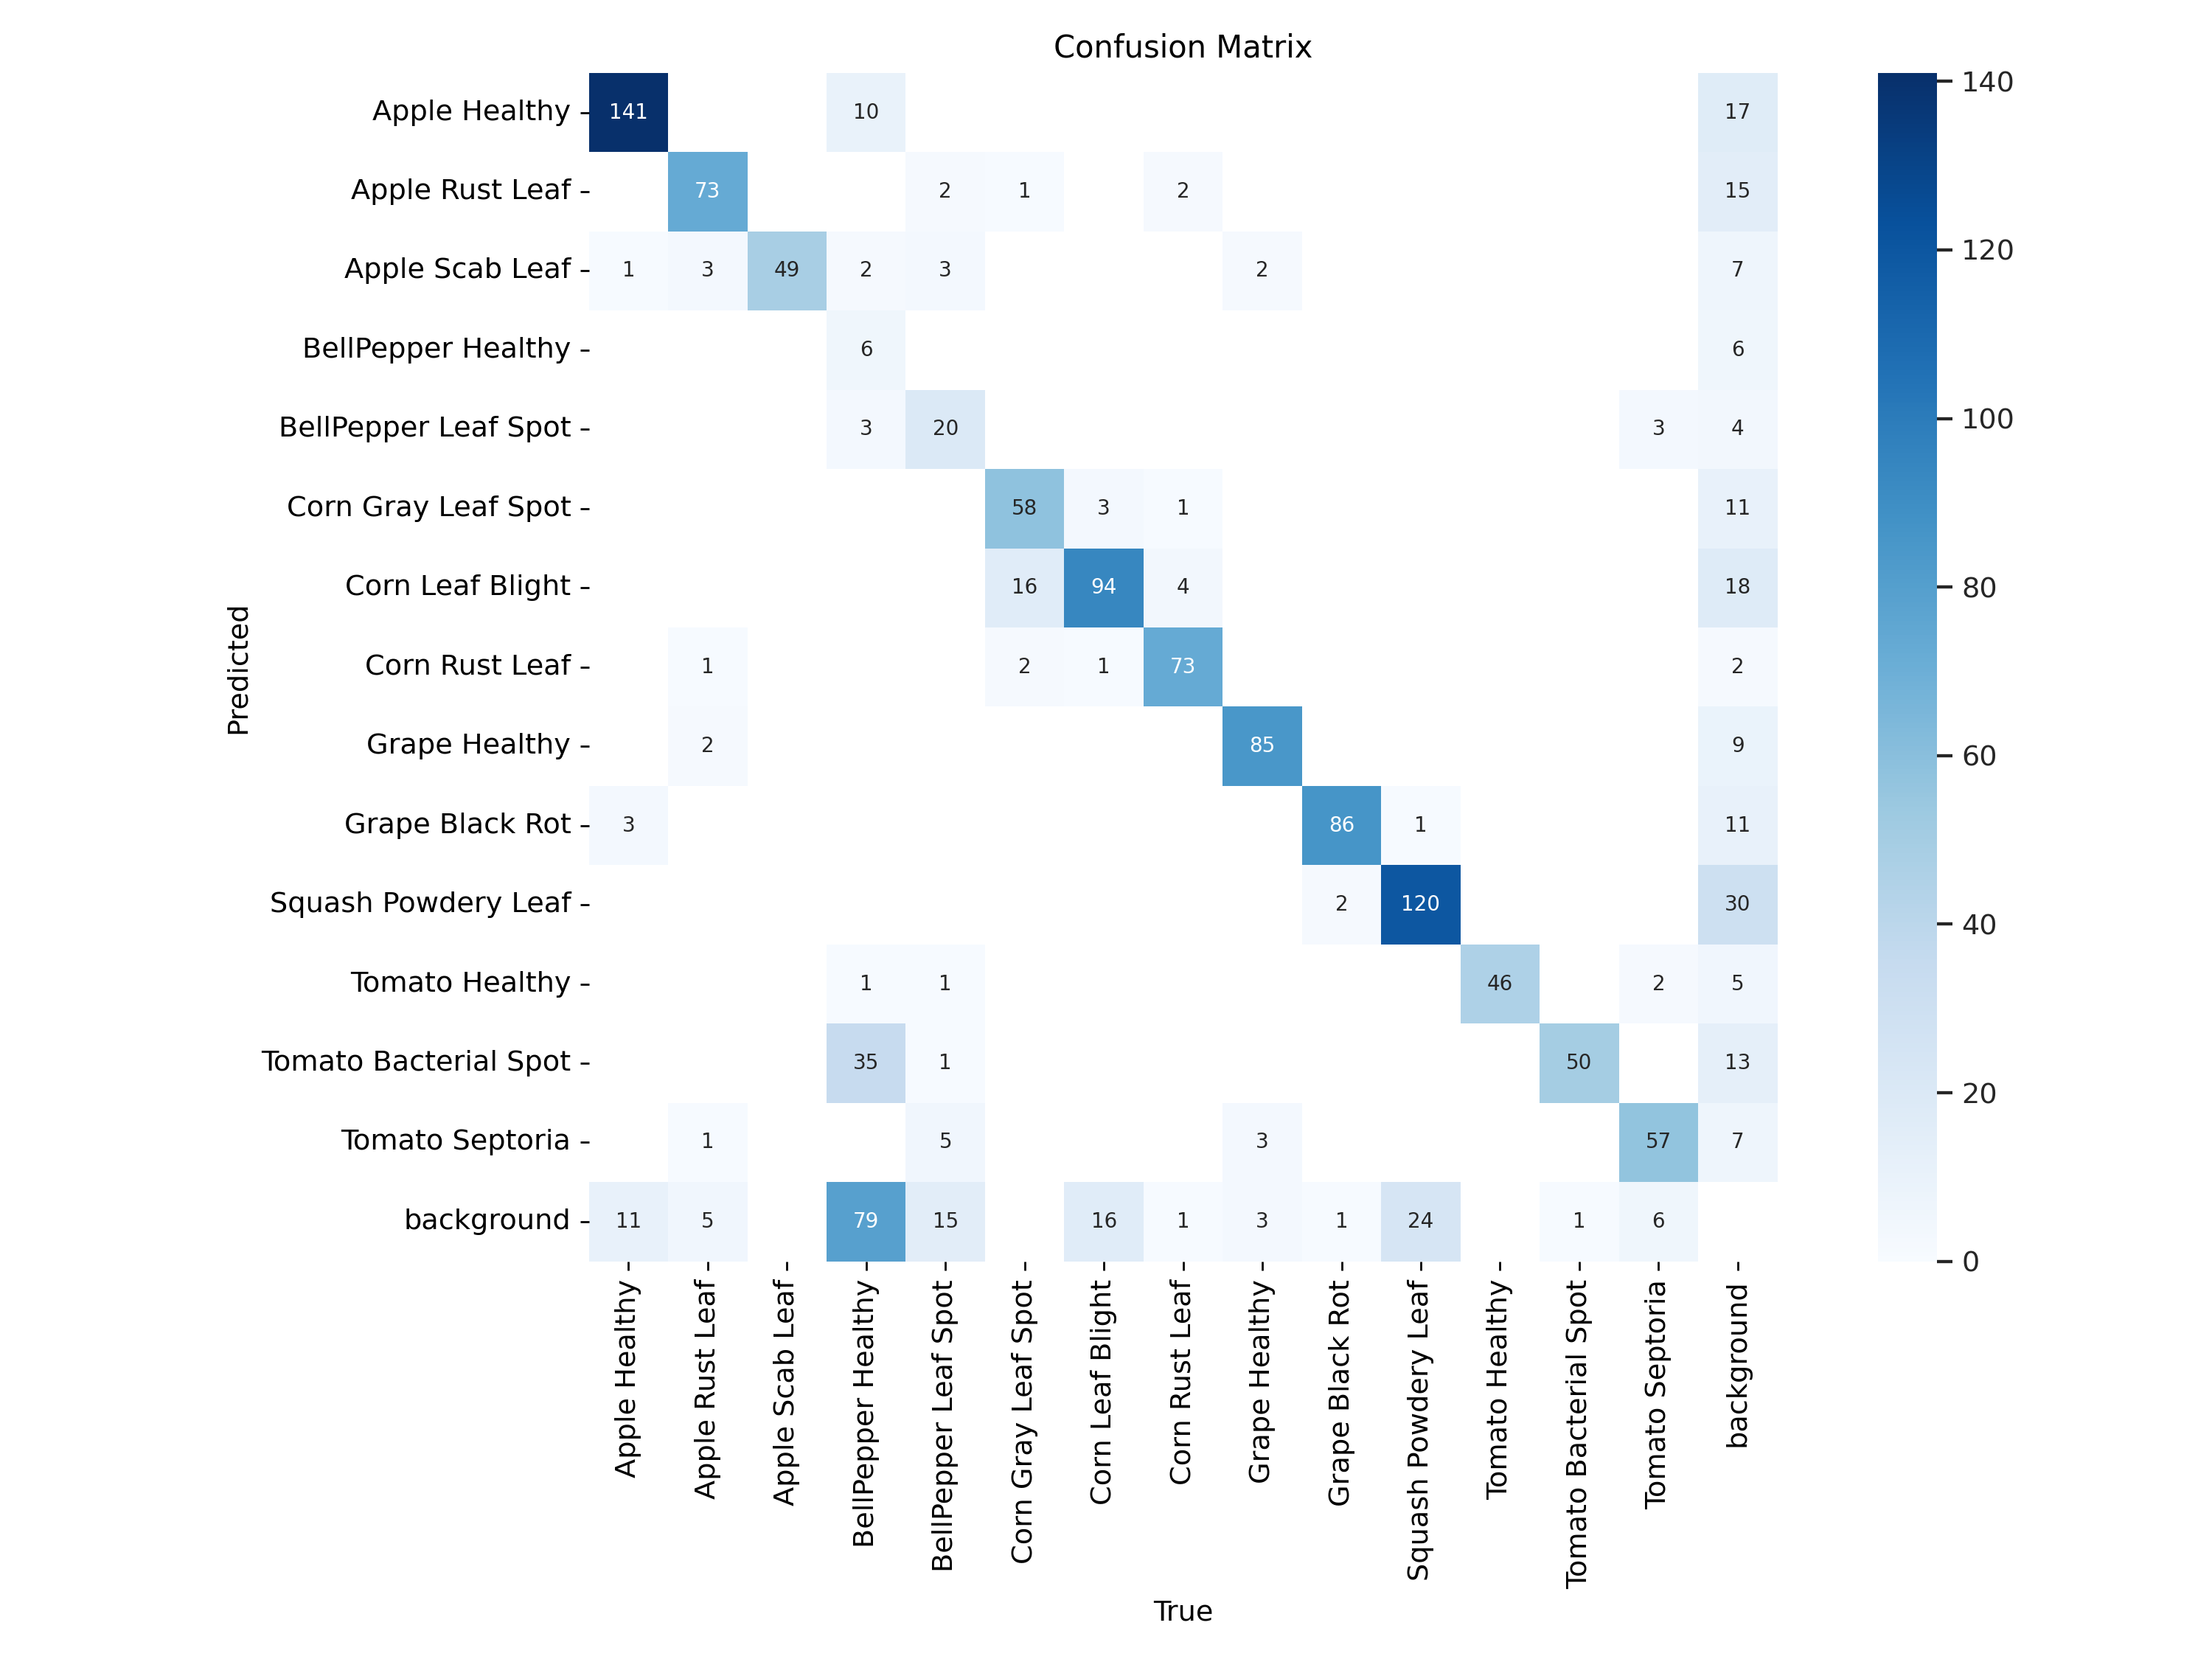

In [ ]:
from IPython.display import Image

image_path = '/Desktop/PlantVillage Dataset-1/training_results/resultsfinalLarge/confusion_matrix.png'
Image(filename=image_path, width=600)


# Ensemble Learning

In [1]:
yolo_accuracy = yolo_map50  

x = vit_accuracy / (vit_accuracy + yolo_accuracy)  # Normalized weight for ViT
y = yolo_accuracy / (vit_accuracy + yolo_accuracy)  # Normalized weight for YOLO

# Ensemble accuracy calculation
ensemble_accuracy = (alpha * vit_accuracy) + (beta * yolo_accuracy)

# Output results
print("=== Model Performance Summary ===")
print(f"ViT Model Accuracy: {vit_accuracy:.2f}%")
print(f"YOLOv8 Model Accuracy (mAP50 as proxy): {yolo_accuracy:.2f}%")
print(f"Weighted Ensemble Accuracy: {ensemble_accuracy:.2f}%")


=== Model Performance Summary ===
ViT Model Accuracy: 91.00%
YOLOv8 Model Accuracy (mAP50 as proxy): 47.10%
Weighted Ensemble Accuracy: 76.03%


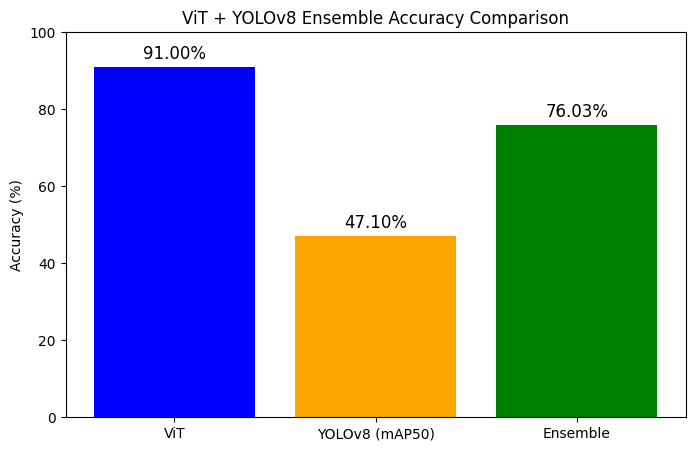

In [2]:
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=["blue", "orange", "green"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("ViT + YOLOv8 Ensemble Accuracy Comparison")
plt.text(0, vit_accuracy + 2, f"{vit_accuracy:.2f}%", ha="center", fontsize=12)
plt.text(1, yolo_accuracy + 2, f"{yolo_accuracy:.2f}%", ha="center", fontsize=12)
plt.text(2, ensemble_accuracy + 2, f"{ensemble_accuracy:.2f}%", ha="center", fontsize=12)
plt.show()

###  **"Hence, after applying ensemble learning, we did not achieve a significant improvement in accuracy. Therefore, we are using the ViT (Vision Transformer) model for plant/crop disease detection."**